# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Business Understanding

For completing this project, I am going to answer the questions below

**1. How to maximize the benifits by giving customers the offers?** 

To answer this question, we need to decied what kinds of user groups will react to the offer. In this article, I'm going to use the FunkSVD method to build a model to predict the user reactions to offers.

Before we answer the questions, we are going to do the data wrangling process first to clean the data so it can be analyzed.

# Data Wrangling

Let's first import the necessary libraries and have a glance at the data.

In [462]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import datetime
import progressbar
import pickle
from matplotlib import pyplot as plt
%matplotlib inline

In [463]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Understanding and Cleaning

### Portfolio Data

In [464]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


There's only 10 kinds of offers

### Profile Data

In [465]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [466]:
# Check if there's any duplicated ids
profile['id'].duplicated().sum()

0

In [467]:
# Check the NaN value proportion
profile.isna().sum()/len(profile)

gender              0.127941
age                 0.000000
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64

In [468]:
# Proportion of rows contain a NaN value
len(profile.dropna())/len(profile)

0.8720588235294118

Since the rows containing NaN values are only 12.8% in the profile data, we can drop those rows.

In [469]:
profile = profile.dropna()

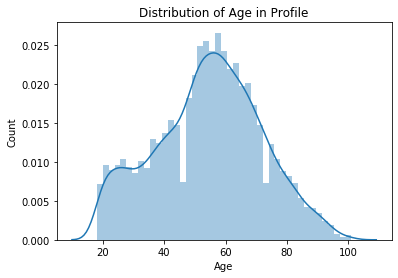

In [470]:
# Check the age distribution of the profile data
sns.distplot(profile['age'],hist=True)
plt.title("Distribution of Age in Profile")
plt.xlabel("Age")
plt.ylabel("Count");

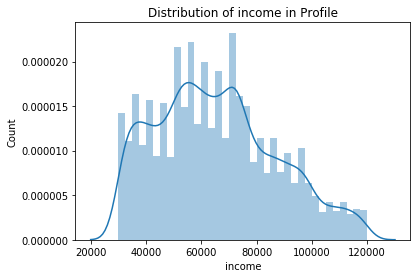

In [471]:
# Check the income distribution of the profile data
sns.distplot(profile['income'],hist=True)
plt.title("Distribution of income in Profile")
plt.xlabel("income")
plt.ylabel("Count");

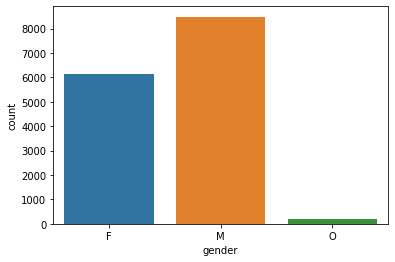

In [281]:
# Check the distribution of the gender
sns.countplot(x='gender',data=profile);

### Transcript Data

In [282]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [283]:
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [284]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [285]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

## Data Processing

In [286]:
# Clean the portfolio data
def clean_portfolio(portfolio):
    '''
    data cleaning the portfolio dataframe
    
    INPUT:
    portfolio - the portfolio dataframe to be cleaned
    
    OUTPUT:
    portfolio - the cleaned portfolio dataframe
    
    '''
    # change the duration from day to hour
    cleaned_portfolio = portfolio.copy()
    cleaned_portfolio['duration'] = cleaned_portfolio['duration'] * 24
    
    # apply one hot encoding to channels column
    cleaned_portfolio['web'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    cleaned_portfolio['email'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    cleaned_portfolio['mobile'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    cleaned_portfolio['social'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    # apply one hot encoding to offer_type column
    offer_type = pd.get_dummies(cleaned_portfolio['offer_type'])
    
    # drop the channels and offer_type column
    cleaned_portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)
    
    # combine the portfolio and offer_type dataframe to form a cleaned dataframe
    cleaned_portfolio = pd.concat([cleaned_portfolio, offer_type], axis=1, sort=False)
    
    # rename the column id to offer_id
    cleaned_portfolio = cleaned_portfolio.rename(columns = {'id' : 'offer_id'})
    
    return cleaned_portfolio
    
cleaned_portfolio = clean_portfolio(portfolio)

In [287]:
cleaned_portfolio

,reward,difficulty,duration,offer_id,web,email,mobile,social,bogo,discount,informational
0,10,10,168,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,96,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0
5,3,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,240,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,72,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,1
8,5,5,120,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,168,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,0,1,0


In [288]:
# Clean profile data
def clean_profile(profile):
    '''
    data cleaning the profile dataframe
    
    INPUT:
    profile - the profile dataframe to be cleaned
    
    OUTPUT:
    profile - the cleaned profile dataframe
    
    '''
    # the number of days since the user is a memeber of starbucks
    profile['member_days'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
    profile['member_days'] = profile['member_days'].dt.days
    
    # rename the column id to user_id
    profile = profile.rename(columns = {'id' : 'user_id'})
    
    return profile

cleaned_profile = clean_profile(profile)

In [289]:
cleaned_profile.head()

,gender,age,user_id,became_member_on,income,member_days
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1309
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,1376
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,1024
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,1100
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,1190


In [290]:
# Clean transcript data
def clean_transcript(transcript):
    '''
    data cleaning the transcript dataframe, return usable dataframe need contain offer events
    
    INPUT:
    transcript - the transcript dataframe to be cleaned
    
    OUTPUT:
    offer - the cleaned offer dataframe
    
    '''
    # Keep those only offer related rows
    offer = transcript[transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]
    
    # extract the offer id from value column, and delete the old value column
    offer['offer_id'] = offer['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])
    offer = offer.drop('value', axis=1)
    
    # rename the column name of person to user_id
    offer = offer.rename(columns={'person':'user_id'})
    
    # sort the value in a ascending order by user_id, time
    offer = offer.sort_values(['user_id', 'time'])
    
    return offer
offer = clean_transcript(transcript)

/Users/clin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [291]:
offer.head()

,user_id,event,time,offer_id
55972,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837
113605,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed
153401,0009655768c64bdeb2e877511632db8f,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d


In [292]:
# merge profile and portfolio to offer table
offer = offer.merge(cleaned_profile, how='inner', on='user_id')

In [293]:
offer = offer.merge(cleaned_portfolio, how='inner', on='offer_id')

In [294]:
offer.head()

,user_id,event,time,offer_id,gender,age,became_member_on,income,member_days,reward,difficulty,duration,web,email,mobile,social,bogo,discount,informational
0,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,M,33,20170421,72000.0,1394,0,0,72,0,1,1,1,0,0,1
1,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,M,33,20170421,72000.0,1394,0,0,72,0,1,1,1,0,0,1
2,0011e0d4e6b944f998e987f904e8c1e5,offer received,336,5a8bc65990b245e5a138643cd4eb9837,O,40,20180109,57000.0,1131,0,0,72,0,1,1,1,0,0,1
3,0011e0d4e6b944f998e987f904e8c1e5,offer viewed,354,5a8bc65990b245e5a138643cd4eb9837,O,40,20180109,57000.0,1131,0,0,72,0,1,1,1,0,0,1
4,0020c2b971eb4e9188eac86d93036a77,offer received,504,5a8bc65990b245e5a138643cd4eb9837,F,59,20160304,90000.0,1807,0,0,72,0,1,1,1,0,0,1


In [295]:
# check the transcript records for the same user
offer[offer['user_id']=='0011e0d4e6b944f998e987f904e8c1e5']

,user_id,event,time,offer_id,gender,age,became_member_on,income,member_days,reward,difficulty,duration,web,email,mobile,social,bogo,discount,informational
2,0011e0d4e6b944f998e987f904e8c1e5,offer received,336,5a8bc65990b245e5a138643cd4eb9837,O,40,20180109,57000.0,1131,0,0,72,0,1,1,1,0,0,1
3,0011e0d4e6b944f998e987f904e8c1e5,offer viewed,354,5a8bc65990b245e5a138643cd4eb9837,O,40,20180109,57000.0,1131,0,0,72,0,1,1,1,0,0,1
12518,0011e0d4e6b944f998e987f904e8c1e5,offer received,0,3f207df678b143eea3cee63160fa8bed,O,40,20180109,57000.0,1131,0,0,96,1,1,1,0,0,0,1
12519,0011e0d4e6b944f998e987f904e8c1e5,offer viewed,6,3f207df678b143eea3cee63160fa8bed,O,40,20180109,57000.0,1131,0,0,96,1,1,1,0,0,0,1
71713,0011e0d4e6b944f998e987f904e8c1e5,offer received,168,2298d6c36e964ae4a3e7e9706d1fb8c2,O,40,20180109,57000.0,1131,3,7,168,1,1,1,1,0,1,0
71714,0011e0d4e6b944f998e987f904e8c1e5,offer viewed,186,2298d6c36e964ae4a3e7e9706d1fb8c2,O,40,20180109,57000.0,1131,3,7,168,1,1,1,1,0,1,0
71715,0011e0d4e6b944f998e987f904e8c1e5,offer completed,252,2298d6c36e964ae4a3e7e9706d1fb8c2,O,40,20180109,57000.0,1131,3,7,168,1,1,1,1,0,1,0
89633,0011e0d4e6b944f998e987f904e8c1e5,offer received,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,O,40,20180109,57000.0,1131,5,20,240,1,1,0,0,0,1,0
89634,0011e0d4e6b944f998e987f904e8c1e5,offer viewed,432,0b1e1539f2cc45b7b9fa7c272da2e1d7,O,40,20180109,57000.0,1131,5,20,240,1,1,0,0,0,1,0
89635,0011e0d4e6b944f998e987f904e8c1e5,offer completed,576,0b1e1539f2cc45b7b9fa7c272da2e1d7,O,40,20180109,57000.0,1131,5,20,240,1,1,0,0,0,1,0


## Modeling
In thi section we are going to create the user_offer_matrix and implement the FunkSVD modeling.

In [316]:
df_test = offer[offer['user_id'] == '0011e0d4e6b944f998e987f904e8c1e5']

The function below is to identify the successful offers, and it takes time to execute.
If you want to save time, just execute the commands below to load directly from saved data.

with open('offer_suc.pickle', 'rb') as handle:

    offer_suc = pickle.load(handle)

In [330]:
# define a function to identify a successful orffer: i.e., an offer that was viewd then completed
def successful_offers(offer):
    '''
    Insert a column of successful orffers: i.e., an offer that was viewd then completed.
    
    INPUT:
    offer - the cleaned offer data
    
    OUTPUT:
    offer_suc - offer data with successful order column added
    
    '''    
    # initialize the successful column to 0
    offer_suc = offer.copy()
    offer_suc['successful_offer'] = 0
    # list of the users
    user_list = offer_suc['user_id'].unique()
    
    # initiate the progressbar
    bar = progressbar.ProgressBar(maxval=len(user_list), \
                widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    i = 0
    # iterate with each user to identify successful offers
    for user in user_list:
        bar.update(i)
        
        # initiate a dataframe to contain those offers viewed but not yet completed
        active_offer = pd.DataFrame(columns = ['time', 'offer_id'])
        # iterate with each offer of the user
        for index, row in offer_suc[offer_suc['user_id'] == user].iterrows():
            # if the event is offer viewed, add the offer to the active list
            if row['event'] == 'offer viewed':
                # if the offer_id is already in the active list, delete those old active offers
                if row['offer_id'] in list(active_offer['offer_id']):
                    active_offer = active_offer[~(active_offer['offer_id'] == row['offer_id'])]
                active_offer = active_offer.append({'time' : row['time'], 'offer_id' : row['offer_id']}, ignore_index=True)
            # determine whether the offer is successful
            if row['event'] == 'offer completed':
                # if the offer completed is active, change the 'successful_offer' value to 1
                if row['offer_id'] in list(active_offer['offer_id']):
                    if int(row['time'] - active_offer[active_offer['offer_id'] == row['offer_id']]['time']) <= int(row['duration']): 
                        offer_suc.at[index,'successful_offer'] = 1
                        active_offer = active_offer[~(active_offer['offer_id'] == row['offer_id'])]
        i = i + 1
    bar.finish()
    return offer_suc

offer_suc = successful_offers(offer)

[========================================================================] 100%


In [332]:
# save the created dataframe
with open('offer_suc.pickle', 'wb') as handle:
    pickle.dump(offer_suc, handle)

In [334]:
# check the number of successful offers
offer_suc.successful_offer.sum()

22586

In [347]:
# def create_user_item_matrix(offer_suc, filename):
#     '''
#     Return the user item matrix that indicate the number of offer successful of a particular user
    
#     INPUT:
#     offer_suc - a cleaned transcript dataframe
#     filename(string) - the file name that save the user item matrix
    
#     OUTPUT:
#     user_item_matrix - the user item matrix which 
#         - row is user 
#         - column is offer
#         - value is the number of offer successful (0 means no offer successful)
#     '''
#     # create an empty user item matrix
#     user_item_matrix = offer_suc.groupby(['user_id', 'offer_id'])['successful_offer'].sum().unstack()
    
#     for offer_id in user_item_matrix.columns:
#         print("Now processing: ", offer_id)
#         num = 0
#         for person in user_item_matrix.index:
#             num += 1
#             if num % 1000 == 0:
#                 print("finished ", num/16994*100, '%')
#             events = []
#             for event in offer[(offer['offer_id']==offer_id) & (offer['person']==person)]['event']:
#                 events.append(event)
#             if len(events) >= 3:
#                 user_item_matrix.loc[person, offer_id] = 0
#                 for i in range(len(events)-2):
#                     # check if the transaction sequence is offer received -> offer viewed -> offer completed
#                     # if yes, we assume the user reacted positively with the offer we provided.
#                     if (events[i] == 'offer received') & (events[i+1] == 'offer viewed') & (events[i+2] == 'offer completed'):
#                         user_item_matrix.loc[person, offer_id] += 1
#             elif len(events) > 0:
#                 user_item_matrix.loc[person, offer_id] = 0
    
#     # store the large martix into file
#     fh = open(filename, 'wb')
#     pickle.dump(user_item_matrix,fh)
#     fh.close()
    
#     return user_item_matrix

In [ ]:
# You can execute the cell here to load the saved data, and omit the process of creating matrix which takes a long time
# with open('user_item_matrix.pickle', 'rb') as handle:
#     user_item_matrix = pickle.load(handle)

In [353]:
# Create user_offer_matrix
user_offer_matrix = offer_suc.groupby(['user_id', 'offer_id'])['successful_offer'].max().unstack()

In [355]:
user_offer_matrix

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
user_id,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,NaN,0.0,NaN,0.0,1.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,NaN,1.0,0.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,NaN,0.0,1.0,NaN,1.0,NaN
003d66b6608740288d6cc97a6903f4f0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...
fff3ba4757bd42088c044ca26d73817a,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,1.0
fff7576017104bcc8677a8d63322b5e1,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,1.0
fff8957ea8b240a6b5e634b6ee8eafcf,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0


In [356]:
# Create the train test set
test_size = 0.3
train_size = int(len(offer_suc) * (1 - test_size))
offer_train = offer_suc[:train_size]
offer_test = offer_suc[train_size:]

In [357]:
user_offer_matrix_train = offer_train.groupby(['user_id', 'offer_id'])['successful_offer'].max().unstack()
user_offer_matrix_test = offer_test.groupby(['user_id', 'offer_id'])['successful_offer'].max().unstack()

In [358]:
user_offer_matrix_train

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
user_id,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,NaN,0.0,0.0,1.0,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,0.0,1.0,1.0,NaN
003d66b6608740288d6cc97a6903f4f0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...
fff3ba4757bd42088c044ca26d73817a,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1.0
fff7576017104bcc8677a8d63322b5e1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
fff8957ea8b240a6b5e634b6ee8eafcf,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0


In [359]:
user_offer_matrix_test

offer_id,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd
user_id,,,
0020c2b971eb4e9188eac86d93036a77,1.0,NaN,0.0
004c5799adbf42868b9cff0396190900,NaN,NaN,0.0
005500a7188546ff8a767329a2f7c76a,NaN,NaN,0.0
00715b6e55c3431cb56ff7307eb19675,0.0,NaN,0.0
00857b24b13f4fe0ad17b605f00357f5,0.0,NaN,0.0
...,...,...,...
fff3ba4757bd42088c044ca26d73817a,NaN,0.0,NaN
fff7576017104bcc8677a8d63322b5e1,0.0,0.0,0.0
fff8957ea8b240a6b5e634b6ee8eafcf,0.0,NaN,NaN


In [360]:
def FunkSVD(complete_mat, latent_features=12, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    complete_mat - (numpy array) a matrix with users as rows, offers as columns, and offer succeeded as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    offer_mat - (numpy array) a latent feature by offer matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = complete_mat.shape[0]
    n_offers = complete_mat.shape[1]
    num_complete = np.count_nonzero(~np.isnan(complete_mat))
    
    # initialize the user and movie matrices with random values
    user_mat = np.random.rand(n_users, latent_features)
    offer_mat = np.random.rand(latent_features, n_offers)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # keep track of iteration and MSE
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-offer pair
        for i in range(n_users):
            for j in range(n_offers):
                
                # if the rating exists
                if complete_mat[i, j] >= 0:
                    
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = complete_mat[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # print results
        print("%d \t\t %f" % (iteration+1, sse_accum / num_complete))
        
    return user_mat, offer_mat

In [361]:
# Create user-by-offer matrix
train_np = np.array(user_offer_matrix_train)

# Fit FunkSVD with the specified hyper parameters to the training data
user_mat, offer_mat = FunkSVD(train_np, latent_features=15, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.209439
2 		 0.164842
3 		 0.164191
4 		 0.163776
5 		 0.163412
6 		 0.163059
7 		 0.162709
8 		 0.162358
9 		 0.162007
10 		 0.161654
11 		 0.161301
12 		 0.160945
13 		 0.160588
14 		 0.160230
15 		 0.159869
16 		 0.159506
17 		 0.159142
18 		 0.158775
19 		 0.158405
20 		 0.158033
21 		 0.157659
22 		 0.157281
23 		 0.156900
24 		 0.156516
25 		 0.156129
26 		 0.155737
27 		 0.155342
28 		 0.154943
29 		 0.154539
30 		 0.154131
31 		 0.153718
32 		 0.153300
33 		 0.152876
34 		 0.152447
35 		 0.152011
36 		 0.151570
37 		 0.151121
38 		 0.150666
39 		 0.150204
40 		 0.149734
41 		 0.149255
42 		 0.148769
43 		 0.148274
44 		 0.147769
45 		 0.147255
46 		 0.146731
47 		 0.146197
48 		 0.145651
49 		 0.145095
50 		 0.144526
51 		 0.143946
52 		 0.143352
53 		 0.142746
54 		 0.142126
55 		 0.141492
56 		 0.140843
57 		 0.140179
58 		 0.139499
59 		 0.138803
60 		 0.138091
61 		 0.137361
62 		 0.136614
63 		 0.135849
64 		 0

## Evaluation

Evaluate the squared errors for the test set

In [368]:
def predict_reaction(user_matrix, offer_matrix, user_id, offer_id):
    '''
    We can use this to make predictions for how users would react with the offers
    
    INPUT:
    user_matrix - user by latent factor matrix
    offer_matrix - latent factor by offer matrix
    user_id - the user_id from the reviews df
    offer_id - the offer_id according the offers df
    
    OUTPUT:
    pred - the predicted reaction for user_id-offer_id according to FunkSVD
    '''
    try:
        # Use the training data to create a series of users and movies that matches the ordering in training data
        user_ids_series = np.array(user_offer_matrix_train.index)
        offer_ids_series = np.array(user_offer_matrix_train.columns)

        # User row and Movie Column
        user_row = np.where(user_ids_series == user_id)[0][0]
        offer_col = np.where(offer_ids_series == offer_id)[0][0]

        # Take dot product of that row and column in U and V to make prediction
        pred = np.dot(user_matrix[user_row, :], offer_matrix[:, offer_col])
        
        return pred
    
    except:
    
        return None

In [448]:
def validation(user_offer_matrix_test, user_mat, offer_mat):
    '''
    Measure the squared errors for the prediction
        
    INPUT:
    user_offer_matrix_test - user offer matrix for the test set
    user_mat - (numpy array) a user by latent feature matrix
    offer_mat - (numpy array) latent factor by offer matrix
    '''
    num_complete = np.count_nonzero(~np.isnan(user_offer_matrix_test))
    
    sse_accum = 0
    
    for user_id in user_offer_matrix_test.index:
        for offer_id in user_offer_matrix_test.columns:
            if ~np.isnan(user_offer_matrix_test.loc[user_id, offer_id]):
                predict_value = predict_reaction(user_mat, offer_mat, user_id, offer_id)
                if predict_value != None:
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = user_offer_matrix_test.loc[user_id, offer_id] - predict_reaction(user_mat, offer_mat, user_id, offer_id)

                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
    
    return sse_accum / num_complete

In [449]:
# Evaluation
print('The squared erros for the predction to test set is: {}'.format(validation(user_offer_matrix_test, user_mat, offer_mat)))

The squared erros for the predction to test set is: 0.1326772714786486


## Exploratory Analysis of the Reactions to the offers

First let's find out which offer sells the best

                           offer_id       gain
9  fafdcd668e3743c1bb461111dcafc2a4  591046.65
1  2298d6c36e964ae4a3e7e9706d1fb8c2  532381.36
8  f19421c1d4aa40978ebb69ca19b0e20d  477902.53
4  4d5c57ea9a6940dd891ad53e9dbe8da0  442540.29
7  ae264e3637204a6fb9bb56bc8210ddfd  427629.13
2  2906b810c7d4411798c6938adc9daaa5  308060.14
6  9b98b8c7a33c4b65b9aebfe6a799e6d9  305621.05
0  0b1e1539f2cc45b7b9fa7c272da2e1d7  222168.92
3  3f207df678b143eea3cee63160fa8bed       0.00
5  5a8bc65990b245e5a138643cd4eb9837       0.00


Text(0, 0.5, 'Sale Amount')

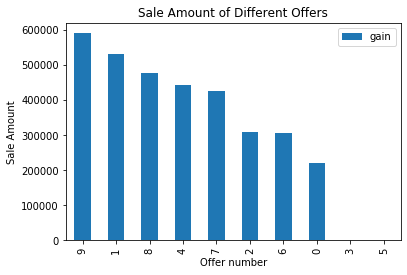

In [381]:
# Find out which offer sells the best

offer_gain = []
for offer_id in user_offer_matrix.columns:
    offer_gain.append([offer_id, transcript[(transcript['person'].isin(list(user_offer_matrix[user_offer_matrix[offer_id]>=1].index)))&(transcript['event']=='transaction')]['value'].apply(lambda x: x['amount']).sum()])

offer_value = pd.DataFrame(offer_gain, columns=['offer_id', 'gain'])
offer_value['gain'] = pd.to_numeric(offer_value['gain'])
offer_value.sort_values(by='gain', ascending=False, inplace=True)
print(offer_value)
    
best_sale = offer_value.plot(kind='bar', title='Sale Amount of Different Offers')
best_sale.set_xlabel('Offer number')
best_sale.set_ylabel('Sale Amount')
    

Next let's get the response distribution by gender

Text(0, 0.5, 'Percentage')

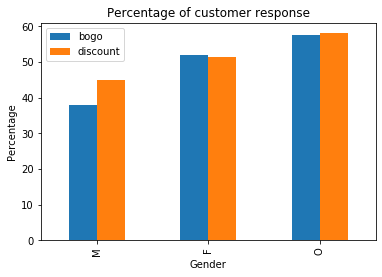

In [382]:
# Get the response distribution by gender
gender_response = pd.DataFrame(data=[[0,0],[0,0],[0,0]], index=['M', 'F', 'O'], columns=['bogo', 'discount'])
gender_sent = pd.DataFrame(data=[[0,0],[0,0],[0,0]], index=['M', 'F', 'O'], columns=['bogo', 'discount'])

# We count the number of offer completed base on the customer gender
for offer_type in ['bogo', 'discount']:
    for offer_id in portfolio[portfolio['offer_type']==offer_type]['id']:
        # count the total number of customers responsed our offers.
        gender_response[offer_type] = gender_response[offer_type].add(profile[profile['id'].isin(user_offer_matrix[user_offer_matrix[offer_id]>0].index)]['gender'].value_counts(), fill_value=0)
        # count the total number of offer sent
        gender_sent[offer_type] = gender_sent[offer_type].add(profile[profile['id'].isin(user_offer_matrix[user_offer_matrix[offer_id]>=0].index)]['gender'].value_counts(), fill_value=0)
        
gender_offer = (gender_response / gender_sent * 100).plot(kind='bar', title='Percentage of customer response')
gender_offer.set_xlabel("Gender")
gender_offer.set_ylabel("Percentage")

It seems males tend to respond to discount rather than bogo, while females tend to respond to offers more than males. The group with gender 'other' tend to response to the offers the most.


Next let's check the response of the user groups by gender to various channels.


In [397]:
profile

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


Text(0, 0.5, 'Percentage')

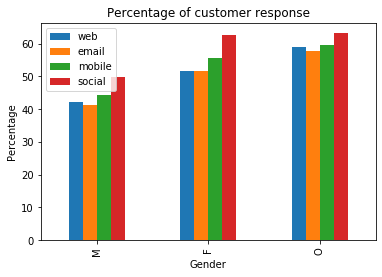

In [398]:
# initialize the gender response and the gender sent dataframe
gender_response = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0]], index=['M', 'F', 'O'], columns=['web', 'email', 'mobile', 'social'])
gender_sent = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0]], index=['M', 'F', 'O'], columns=['web', 'email', 'mobile', 'social'])

# We count the number of offer completed base on the customer gender
for channel_type in ['web', 'email', 'mobile', 'social']:
    for offer_id in cleaned_portfolio[(cleaned_portfolio[channel_type]==1)&(cleaned_portfolio['informational']!=1)]['offer_id']:
        # count the total number of customers responsed our offers.
        gender_response[channel_type] = gender_response[channel_type].add(profile[profile['id'].isin(user_offer_matrix[user_offer_matrix[offer_id]>0].index)]['gender'].value_counts(), fill_value=0)
        # count the total number of offer sent
        gender_sent[channel_type] = gender_sent[channel_type].add(profile[profile['id'].isin(user_offer_matrix[user_offer_matrix[offer_id]>=0].index)]['gender'].value_counts(), fill_value=0)
        
gender_offer = (gender_response / gender_sent * 100).plot(kind='bar', title='Percentage of customer response')
gender_offer.set_xlabel("Gender")
gender_offer.set_ylabel("Percentage")

It seems people tend to response to social channel better, also it shows the same trend that in terms of responsiveness: other gender > females > males.

Since the income often influence how people respond to offers, we would like to check the responsiveness to different offers by different income levels. We divide the users into 4 groups with different income levels: 0-40000, 40000-60000, 60000-80000, and 80000+.

In [444]:
# create the income value column
income_level = []
for income in profile['income']:
    if income <= 40000:
        income_level.append('income_40000')
    elif income > 40000 and income <= 60000:
        income_level.append('income_40000_60000')
    elif income > 60000 and income <= 80000:
        income_level.append('income_60000_80000')
    elif income > 80000:
        income_level.append('income_80000')
profile['income_level'] = income_level

In [428]:
profile.head()

,gender,age,id,became_member_on,income,income_level
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,income_80000
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,income_80000
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,income_60000_80000
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,income_40000_60000
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,income_40000_60000


Text(0, 0.5, 'Percentage')

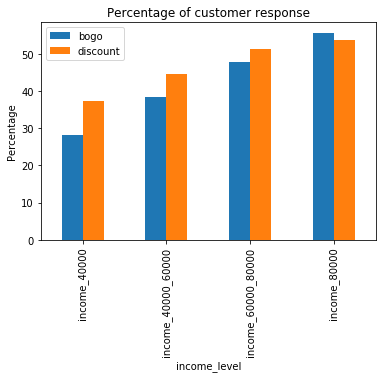

In [430]:
# Get the response distribution to offer types by income level
gender_response = pd.DataFrame(data=[[0,0],[0,0],[0,0], [0,0]], index=['income_40000', 'income_40000_60000', 'income_60000_80000', 'income_80000'], columns=['bogo', 'discount'])
gender_sent = pd.DataFrame(data=[[0,0],[0,0],[0,0], [0,0]], index=['income_40000', 'income_40000_60000', 'income_60000_80000', 'income_80000'], columns=['bogo', 'discount'])

# We count the number of offer completed base on the customer income level
for offer_type in ['bogo', 'discount']:
    for offer_id in portfolio[portfolio['offer_type']==offer_type]['id']:
        # count the total number of customers responsed our offers.
        gender_response[offer_type] = gender_response[offer_type].add(profile[profile['id'].isin(user_offer_matrix[user_offer_matrix[offer_id]>0].index)]['income_level'].value_counts(), fill_value=0)
        # count the total number of offer sent
        gender_sent[offer_type] = gender_sent[offer_type].add(profile[profile['id'].isin(user_offer_matrix[user_offer_matrix[offer_id]>=0].index)]['income_level'].value_counts(), fill_value=0)
        
gender_offer = (gender_response / gender_sent * 100).plot(kind='bar', title='Percentage of customer response')
gender_offer.set_xlabel("income_level")
gender_offer.set_ylabel("Percentage")

It seems people with higher income tend to respond better than those with lower income. Among all the income levels, except those with 80000+$ income, tend to discount better than BOGO.

Also considering people of different ages might react differently to offer channels, we would like to check the responsiveness to different offers by different ages. We divide the users into 4 groups by ages: 0-30, 30-50, 50-70 and 70+.

In [442]:
# create the age_bracket column
age_bracket = []
for age in profile['age']:
    if age <= 30:
        age_bracket.append('age_30')
    elif age > 30 and age <= 50:
        age_bracket.append('age_30_50')
    elif age > 50 and age <= 70:
        age_bracket.append('age_50_70')
    elif age > 70:
        age_bracket.append('age_70')
profile['age_bracket'] = age_bracket

In [445]:
profile.head()

,gender,age,id,became_member_on,income,age_bracket,income_level
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,age_50_70,income_80000
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,age_70,income_80000
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,age_50_70,income_60000_80000
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,age_50_70,income_40000_60000
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,age_50_70,income_40000_60000


Text(0, 0.5, 'Percentage')

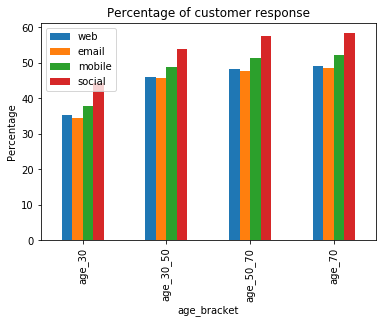

In [446]:
# get the age bracket response to various channels
gender_response = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0], [0,0,0,0]], index=['age_30', 'age_30_50', 'age_50_70', 'age_70'], columns=['web', 'email', 'mobile', 'social'])
gender_sent = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0], [0,0,0,0]], index=['age_30', 'age_30_50', 'age_50_70', 'age_70'], columns=['web', 'email', 'mobile', 'social'])

# We count the number of offer completed base on the customer gender
for channel_type in ['web', 'email', 'mobile', 'social']:
    for offer_id in cleaned_portfolio[(cleaned_portfolio[channel_type]==1)&(cleaned_portfolio['informational']!=1)]['offer_id']:
        # count the total number of customers responsed our offers.
        gender_response[channel_type] = gender_response[channel_type].add(profile[profile['id'].isin(user_offer_matrix[user_offer_matrix[offer_id]>0].index)]['age_bracket'].value_counts(), fill_value=0)
        # count the total number of offer sent
        gender_sent[channel_type] = gender_sent[channel_type].add(profile[profile['id'].isin(user_offer_matrix[user_offer_matrix[offer_id]>=0].index)]['age_bracket'].value_counts(), fill_value=0)
        
gender_offer = (gender_response / gender_sent * 100).plot(kind='bar', title='Percentage of customer response')
gender_offer.set_xlabel("age_bracket")
gender_offer.set_ylabel("Percentage")

Seems youger people tend to respond less to offers than older people.

## Recommend Strategy
Now we can use the trained FunkSVD model to provide offers to our users.
If the user is a new customer, then give him the top offers that gains the most reactions.

In [458]:
def recommend_offer(user_id, user_mat, offer_mat):
    '''
    Make recommend of offers to a given user
        
    INPUT:
    user_id - user id
    user_mat - (numpy array) a user by latent feature matrix
    offer_mat - (numpy array) latent factor by offer matrix
    '''    
    recommend = {}
    for offer_id in user_offer_matrix_train.columns:
        pred_val = predict_reaction(user_mat, offer_mat, user_id, offer_id)
        if pred_val != None:
            recommend[offer_id] = pred_val
        else:
            break
    if pred_val == None:
        print("This is a new user, we will recommend to give him the offers that gains the most responses among all of our users.")
        top_offer = list(offer_value['offer_id'])[:8]
        top_offer_gains = list(offer_value['gain'])[:8]
        for i in range(len(top_offer)):
            print("offer id: {}, gains: {}".format(top_offer[i], top_offer_gains[i]))
    else:
        print("recommend offer for user ", user_id)
        for offer_id, pred_val in sorted(recommend.items(), key=lambda kv:(kv[1], kv[0]), reverse=True):
            print("offer id: ", offer_id, ", predicted number of successful offers: ", round(pred_val,2))

In [460]:
# recommend offer for a particular user
recommend_offer('e2127556f4f64592b11af22de27a7932', user_mat, offer_mat)

recommend offer for user  e2127556f4f64592b11af22de27a7932
offer id:  fafdcd668e3743c1bb461111dcafc2a4 , predicted number of successful offers:  0.97
offer id:  f19421c1d4aa40978ebb69ca19b0e20d , predicted number of successful offers:  0.9
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7 , predicted number of successful offers:  0.65
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2 , predicted number of successful offers:  0.45
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9 , predicted number of successful offers:  0.25
offer id:  2906b810c7d4411798c6938adc9daaa5 , predicted number of successful offers:  0.02
offer id:  3f207df678b143eea3cee63160fa8bed , predicted number of successful offers:  -0.0
offer id:  5a8bc65990b245e5a138643cd4eb9837 , predicted number of successful offers:  -0.0


In [461]:
# recommend offers with highest sales gain to a new user
recommend_offer('new_user', user_mat, offer_mat)

This is a new user, we will recommend to give him the offers that gains the most responses among all of our users.
offer id: fafdcd668e3743c1bb461111dcafc2a4, gains: 591046.65
offer id: 2298d6c36e964ae4a3e7e9706d1fb8c2, gains: 532381.3600000001
offer id: f19421c1d4aa40978ebb69ca19b0e20d, gains: 477902.53
offer id: 4d5c57ea9a6940dd891ad53e9dbe8da0, gains: 442540.29000000004
offer id: ae264e3637204a6fb9bb56bc8210ddfd, gains: 427629.13
offer id: 2906b810c7d4411798c6938adc9daaa5, gains: 308060.13999999996
offer id: 9b98b8c7a33c4b65b9aebfe6a799e6d9, gains: 305621.05
offer id: 0b1e1539f2cc45b7b9fa7c272da2e1d7, gains: 222168.92
